# MFCC / speaker prediction / LSTM

In [35]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [5]:
import sqlite3


conn = sqlite3.connect("./train-clean-100.db")
cur = conn.cursor()
cur.execute('''select distinct readerID, gender from data''' )
obj = cur.fetchall()
conn.close()
print(obj)

[(103, 1), (1034, 0), (1040, 0), (1069, 1), (1081, 0), (1088, 1), (1098, 1), (1116, 1), (118, 0), (1183, 1), (1235, 0), (1246, 1), (125, 1), (1263, 1), (1334, 0), (1355, 0), (1363, 1), (1447, 1), (1455, 0), (150, 1), (1502, 1), (1553, 1), (1578, 1), (1594, 0), (1624, 0), (163, 0), (1723, 0), (1737, 1), (1743, 0), (1841, 1), (1867, 0), (1898, 1), (19, 1), (1926, 1), (196, 0), (1963, 1), (1970, 1), (198, 1), (1992, 1), (200, 1), (2002, 0), (2007, 1), (201, 0), (2092, 1), (211, 1), (2136, 0), (2159, 0), (2182, 1), (2196, 1), (226, 1), (2289, 0), (229, 0), (233, 0), (2384, 0), (2391, 1), (2416, 1), (2436, 0), (248, 1), (250, 1), (2514, 0), (2518, 0), (254, 0), (26, 0), (2691, 1), (27, 0), (2764, 1), (2817, 1), (2836, 1), (2843, 0), (289, 1), (2893, 0), (2910, 1), (2911, 0), (2952, 0), (298, 1), (2989, 1), (302, 1), (307, 0), (311, 0), (3112, 1), (3168, 0), (32, 1), (3214, 0), (322, 1), (3235, 1), (3240, 0), (3242, 0), (3259, 1), (328, 1), (332, 0), (3374, 0), (3436, 0), (3440, 1), (3486, 0

In [6]:
import collections
collections.Counter([j for i,j in obj])


Counter({0: 126, 1: 125})

In [7]:
gender_dict = {k:v for k,v in obj}

In [188]:
def load_wav(file_path):
    from scipy.io.wavfile import read

    wavfile = file_path

    fs, data = read(wavfile)

#     print("Sampling rate :", fs)
#     print("Sample num :",len(data))
    
    return fs,data


def write_wav(file_path, fs, data):
    from scipy.io.wavfile import write
    try:
        write(file_path,fs, data)
        return 1
    except:
        return 0


- sampling rate = 16000 Hz
- 200,000点で，200,000/16,000  = 12.5 sec
- 50 msec くらいで切りたいので，
- 50*10^-3 * 16,000 = 800 点ずつ切ればいい？
- 2の累乗にすると1024くらい？(0.064 sec)

In [116]:
import pickle
with open("mfcc_lstm_data.dump","rb") as f:
    (all_data, all_labels, all_speakers) = pickle.load(f,encoding="bytes")

In [117]:
all_data.shape

(15561, 1024)

In [ ]:
frame_length = 10000
stride = 2500

all_data = np.empty((0,frame_length), int)
all_labels = []
all_speakers = []

cnt = 0
for path in glob.glob("wav_samples/*"):
    fs,data = load_wav(path)
    print(cnt,path)
    
    frame_num = int((data.shape[0]-frame_length)/stride) 
    for i in range(frame_num):
        all_data = np.append(all_data, np.array([data[i*stride:i*stride+frame_length]]), axis=0)

    label = gender_dict[int(path.split("/")[1].split("-")[0])]
    all_labels.extend([label]*frame_num)
    all_speakers.extend([cnt]*frame_num)
    
    cnt += 1
#     if cnt > 80:
#         break
    
print(all_data.shape)
all_labels = np.array(all_labels)

0 wav_samples/103-1240-0000.flac.wav
1 wav_samples/1034-121119-0000.flac.wav
2 wav_samples/1040-133433-0000.flac.wav
3 wav_samples/1069-133699-0000.flac.wav
4 wav_samples/1081-125237-0000.flac.wav
5 wav_samples/1088-129236-0000.flac.wav
6 wav_samples/1098-133695-0000.flac.wav
7 wav_samples/1116-132847-0000.flac.wav
8 wav_samples/118-121721-0000.flac.wav
9 wav_samples/1183-124566-0000.flac.wav
10 wav_samples/1235-135883-0000.flac.wav
11 wav_samples/1246-124548-0000.flac.wav
12 wav_samples/125-121124-0000.flac.wav
13 wav_samples/1263-138246-0000.flac.wav
14 wav_samples/1334-135589-0000.flac.wav
15 wav_samples/1355-39947-0000.flac.wav
16 wav_samples/1363-135842-0000.flac.wav
17 wav_samples/1447-130550-0000.flac.wav
18 wav_samples/1455-134435-0000.flac.wav
19 wav_samples/150-126107-0000.flac.wav
20 wav_samples/1502-122615-0000.flac.wav
21 wav_samples/1553-140047-0000.flac.wav
22 wav_samples/1578-140045-0000.flac.wav
23 wav_samples/1594-135914-0000.flac.wav
24 wav_samples/1624-142933-0000.f

In [208]:
# import pickle
# with open("mfcc_lstm_data_10000.dump","wb") as f:
#     pickle.dump((all_data, all_labels, all_speakers),f)

In [195]:
print(all_data.shape)
print(all_labels.shape)
# print(all_speakers.shape)

(15237, 4096)
(15237,)


In [212]:
all_data_label_speaker = np.array([(x,y,z) for x,y,z in zip(all_data,all_labels,all_speakers) if np.max(x)>1000.])
all_data = np.array([x for x,y,z in all_data_label_speaker])
all_labels = np.array([y for x,y,z in all_data_label_speaker])
all_speakers = np.array([z for x,y,z in all_data_label_speaker])

In [213]:
all_data.shape

(2849, 10000)

In [198]:
x_train = all_data[:10000]
y_train = all_labels[:10000]
x_test = all_data[10000:]
y_test = all_labels[10000:]
s_train = all_speakers[:10000]
s_test = all_speakers[10000:]

In [127]:
y_train[500:800]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [205]:
path ="./wav_samples/103-1240-0000.flac.wav"
fs,data = load_wav(path)
write_wav("test.wav",fs,data[:20000])

1

0.256 3.90625
mean: 16.4509277344 std: 282.79852354 mean/std: 0.058171901071
mean: 2485.51660859 std: 9473.77860612 mean/std: 0.262357472338
191957.153637 49483.5191753 3.87921386425
max-val: 191957.153637 max-freq: 3.90625 max/std: 20.2619421054
mfcc shape (20, 13)


/Users/kazuki/.pyenv/versions/3.6.1/lib/python3.6/site-packages/librosa/filters.py:261: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


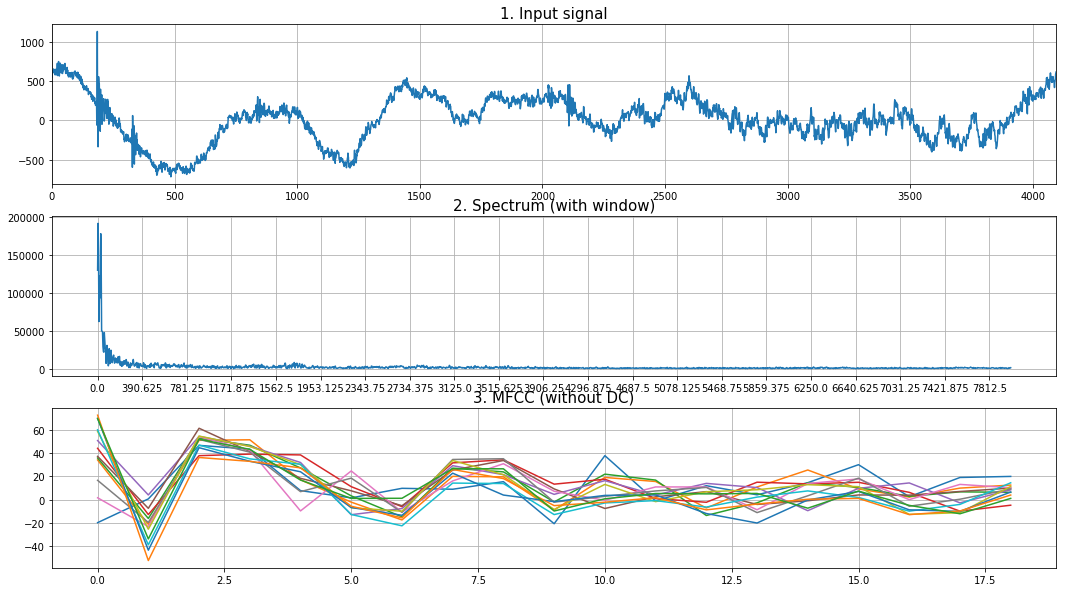

0.256 3.90625
mean: 64.6623535156 std: 604.799594753 mean/std: 0.106915338695
mean: 5041.68649874 std: 16803.0675589 mean/std: 0.300045600665
346951.018652 191229.295135 1.81431939289
max-val: 346951.018652 max-freq: 23.4375 max/std: 20.6480761584
mfcc shape (20, 13)


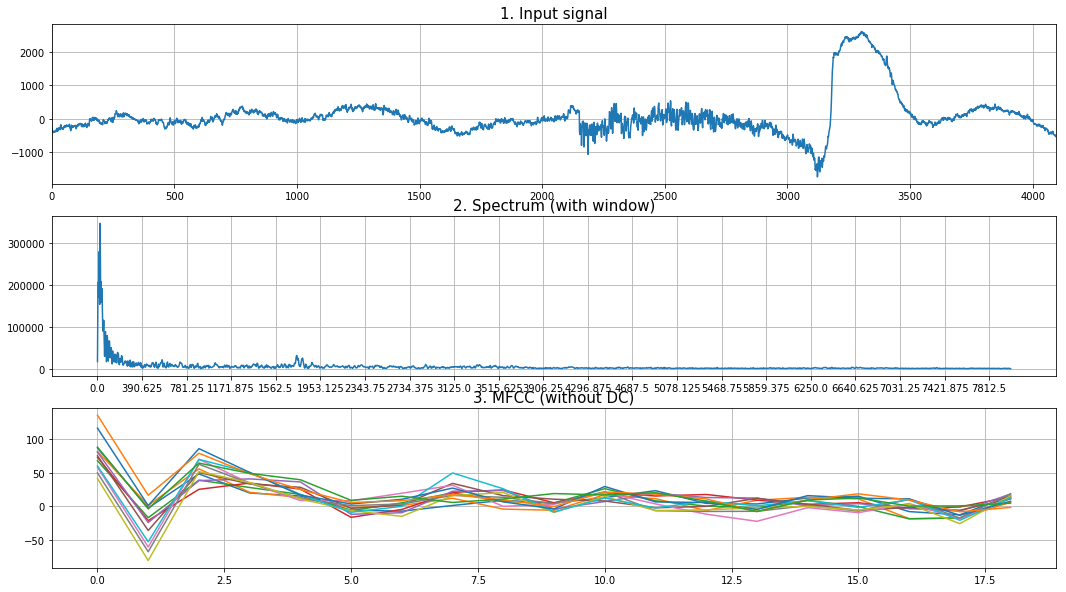

0.256 3.90625
mean: 107.010986328 std: 1183.17386823 mean/std: 0.090444007598
mean: 7431.63753583 std: 36812.9941485 mean/std: 0.201875389593
576598.810765 372532.625493 1.5477807078
max-val: 576598.810765 max-freq: 7.8125 max/std: 15.6629153401
mfcc shape (20, 13)


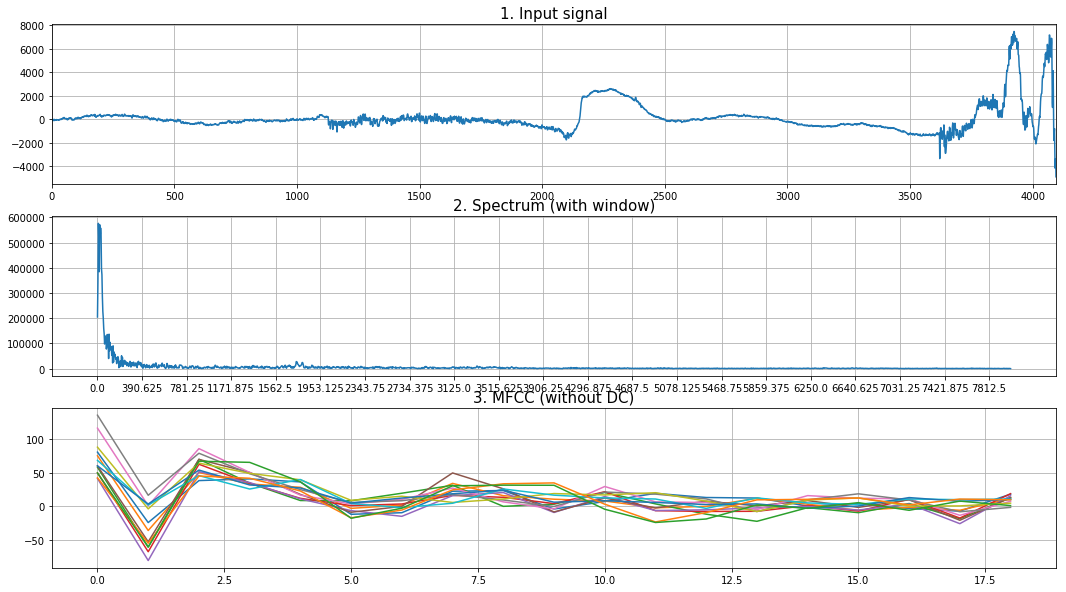

0.256 3.90625
mean: -24.7561035156 std: 2335.31078086 mean/std: -0.0106007747314
mean: 17801.5741923 std: 64355.5827813 mean/std: 0.27661274163
1116848.28708 694129.613491 1.60899098003
max-val: 1116848.28708 max-freq: 19.53125 max/std: 17.3543341356
mfcc shape (20, 13)


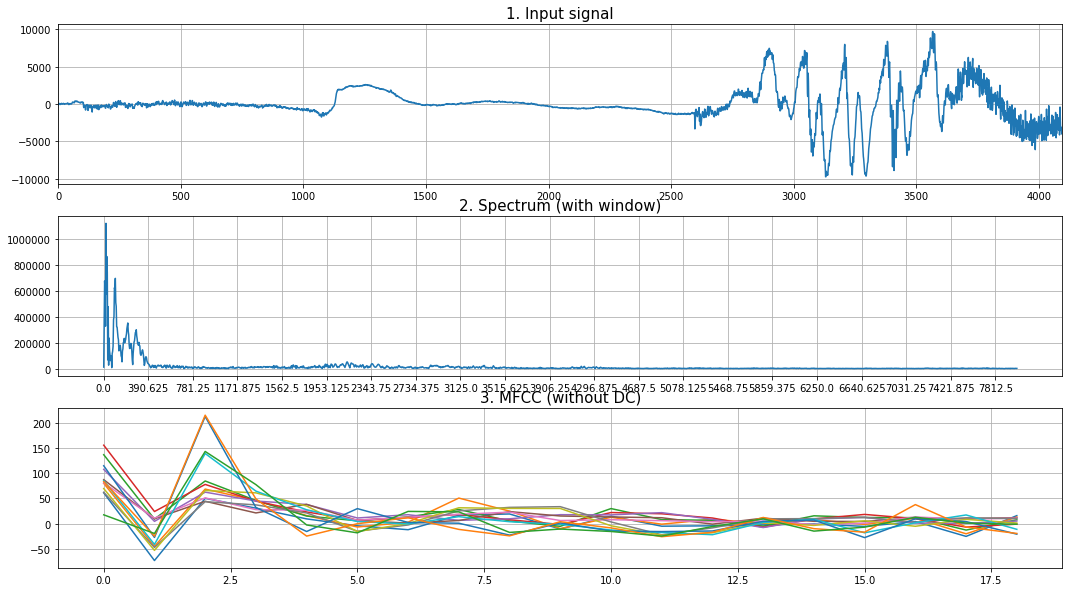

0.256 3.90625
mean: 7.49462890625 std: 2456.58684991 mean/std: 0.00305083001911
mean: 42016.8255483 std: 126155.933224 mean/std: 0.33305469251
2172878.77373 1520995.43201 1.42858994051
max-val: 2172878.77373 max-freq: 19.53125 max/std: 17.2237541128
mfcc shape (20, 13)


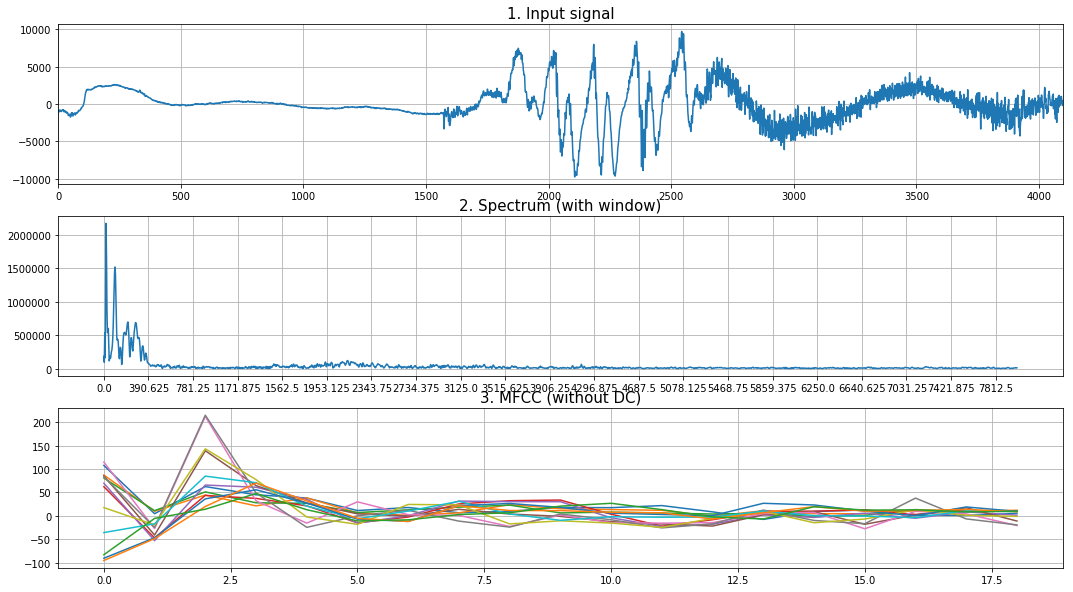

0.256 3.90625
mean: -116.733398438 std: 3302.60532073 mean/std: -0.0353458518657
mean: 47204.4957741 std: 107889.346763 mean/std: 0.437526940244
2567848.88068 1139825.92937 2.2528430127
max-val: 2567848.88068 max-freq: 19.53125 max/std: 23.8007640024
mfcc shape (20, 13)


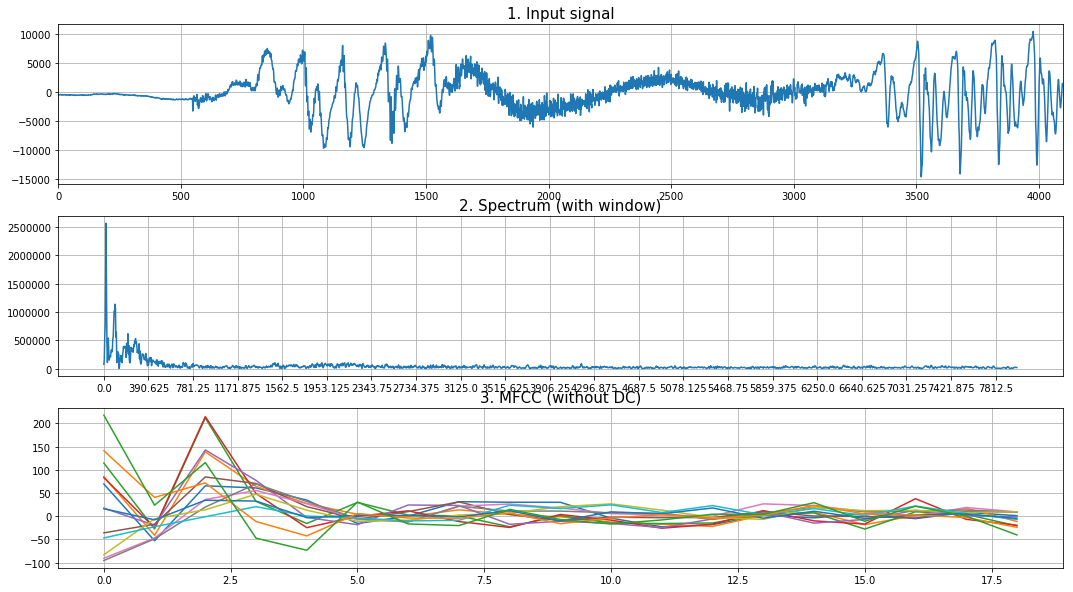

0.256 3.90625
mean: -103.083251953 std: 4895.73420015 mean/std: -0.0210557288731
mean: 55328.2571581 std: 130025.858965 mean/std: 0.425517336308
1758415.86008 1563961.48078 1.12433450676
max-val: 1758415.86008 max-freq: 19.53125 max/std: 13.5235858011
mfcc shape (20, 13)


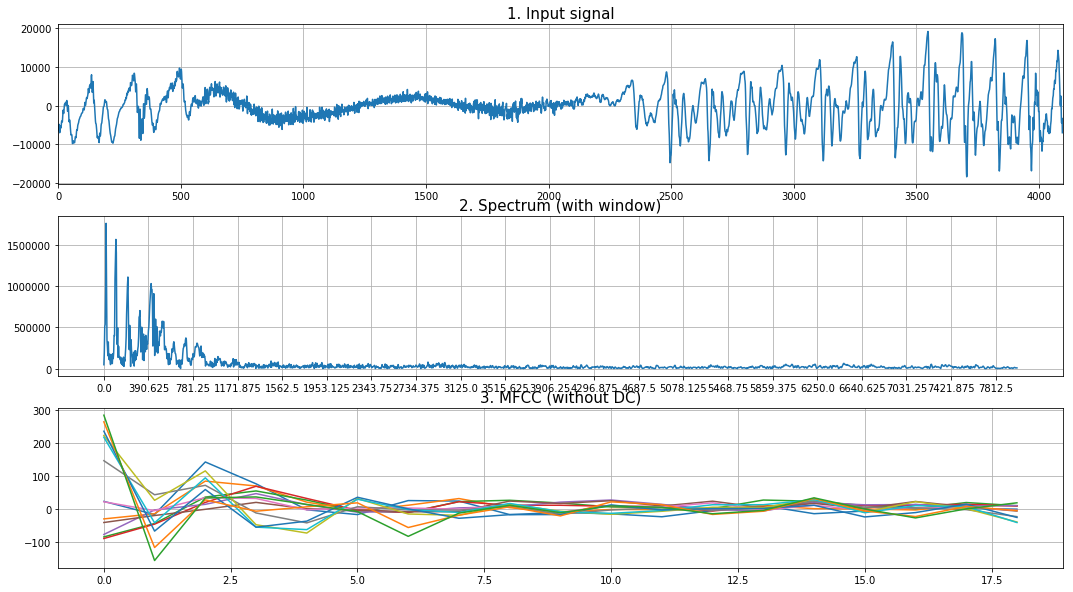

0.256 3.90625
mean: 2.76708984375 std: 4622.53402861 mean/std: 0.000598608864018
mean: 81286.2334285 std: 227473.798068 mean/std: 0.357343281375
1173580.47515 2598332.14011 0.451666843141
max-val: 2598332.14011 max-freq: 109.375 max/std: 11.42255575
mfcc shape (20, 13)


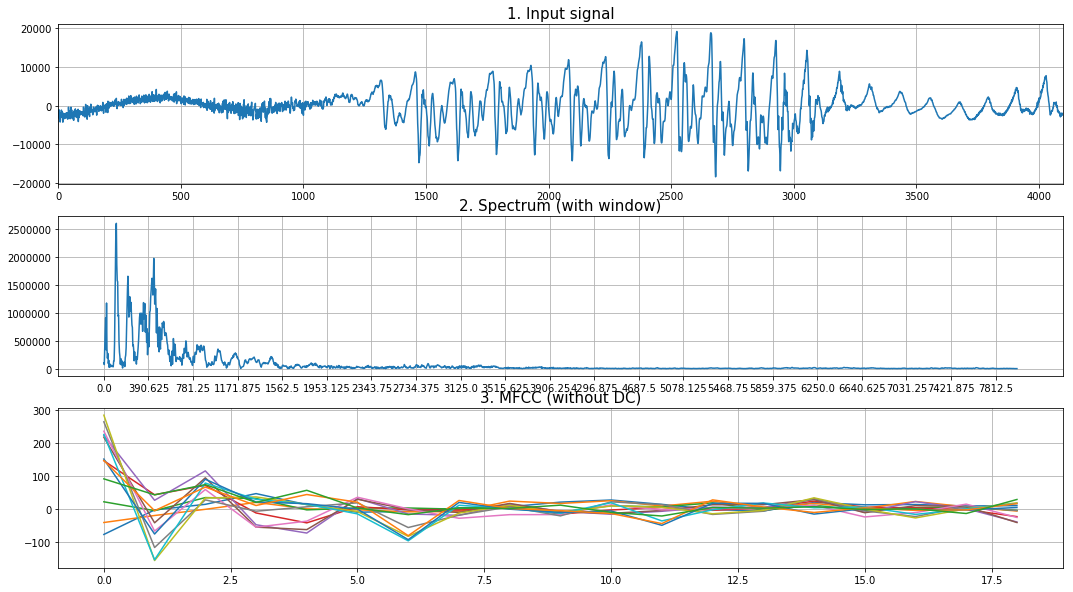

0.256 3.90625
mean: 111.046386719 std: 5303.85892979 mean/std: 0.0209369042783
mean: 79041.9427107 std: 213826.395582 mean/std: 0.369654749572
1110711.73859 2309867.97766 0.480855074548
max-val: 2309867.97766 max-freq: 121.09375 max/std: 10.8025390008
mfcc shape (20, 13)


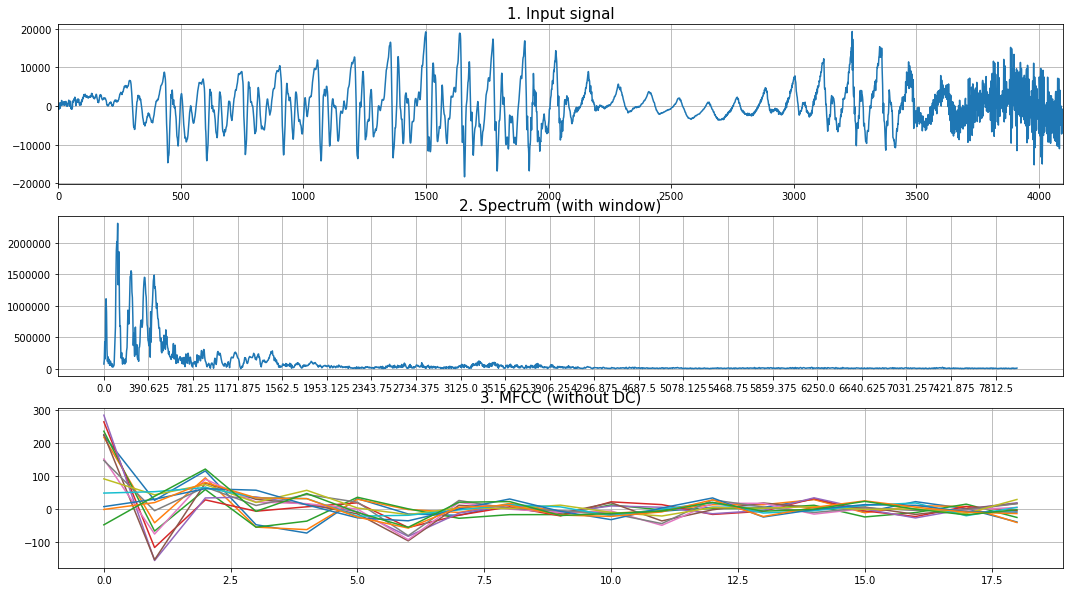

0.256 3.90625
mean: -4.58325195312 std: 5565.30471451 mean/std: -0.00082354016325
mean: 92946.2966592 std: 159401.071874 mean/std: 0.583097061812
1317058.04154 2590925.95061 0.508334883607
max-val: 2590925.95061 max-freq: 132.8125 max/std: 16.2541312938
mfcc shape (20, 13)


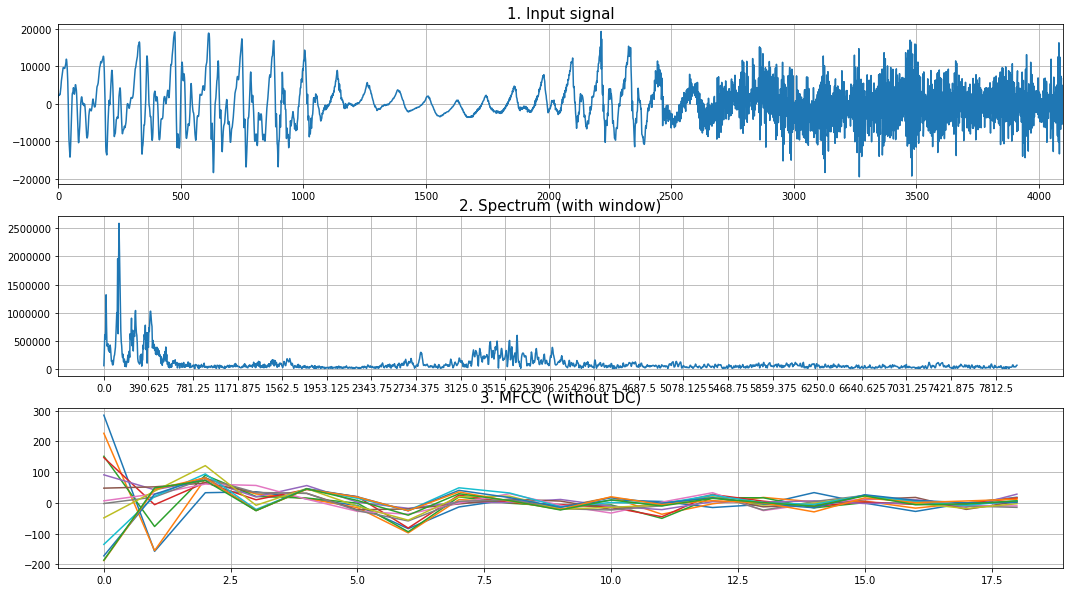

0.256 3.90625
mean: 4.9453125 std: 5953.15369423 mean/std: 0.000830704657397
mean: 141523.368548 std: 173258.487296 mean/std: 0.816833684498
976359.364062 1506320.51031 0.648175044673
max-val: 1506320.51031 max-freq: 136.71875 max/std: 8.69406476889
mfcc shape (20, 13)


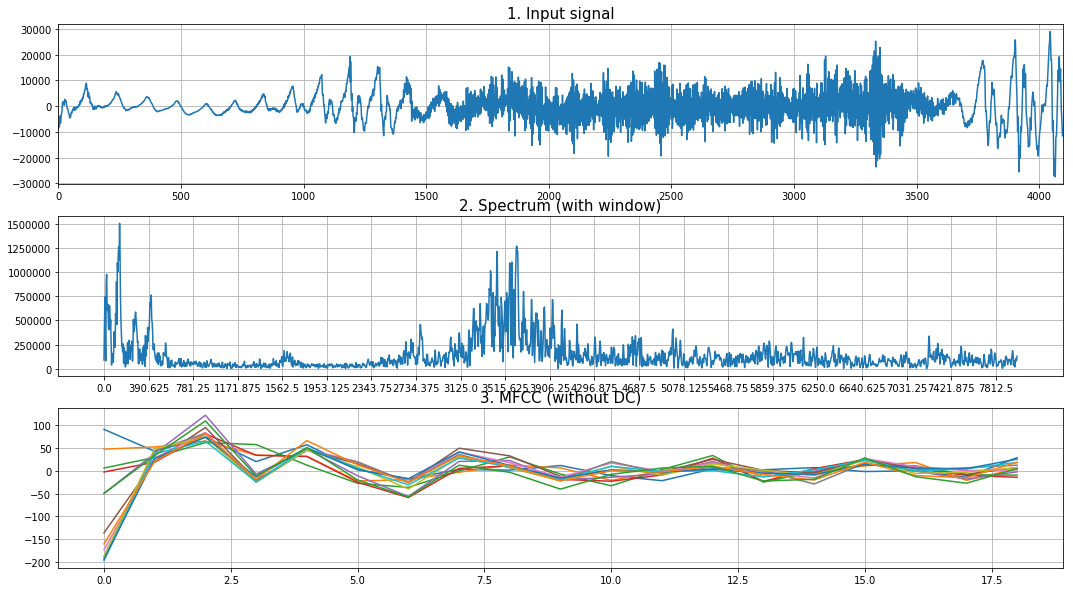

0.256 3.90625
mean: 37.4409179688 std: 7245.52798239 mean/std: 0.0051674519869
mean: 175418.485963 std: 224992.065204 mean/std: 0.779665210877
680242.350569 1896222.72611 0.358735469837
max-val: 1896222.72611 max-freq: 109.375 max/std: 8.42795377871
mfcc shape (20, 13)


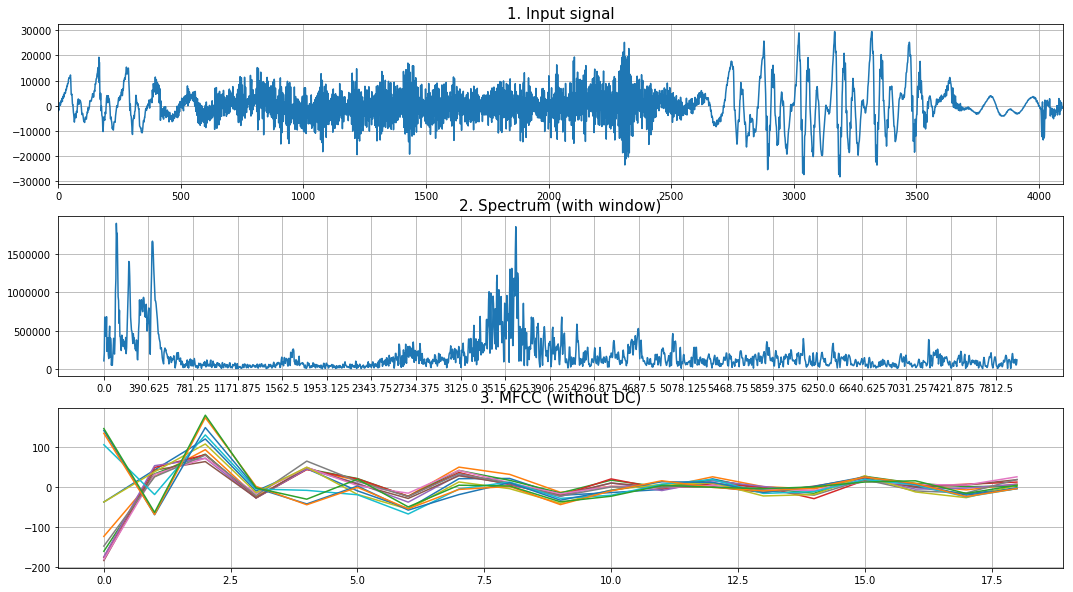

0.256 3.90625
mean: -75.1157226562 std: 7380.46178038 mean/std: -0.0101776453685
mean: 160244.630192 std: 331468.846441 mean/std: 0.483437981917
1346580.34239 3843203.37117 0.350379673502
max-val: 3843203.37117 max-freq: 425.78125 max/std: 11.594463288
mfcc shape (20, 13)


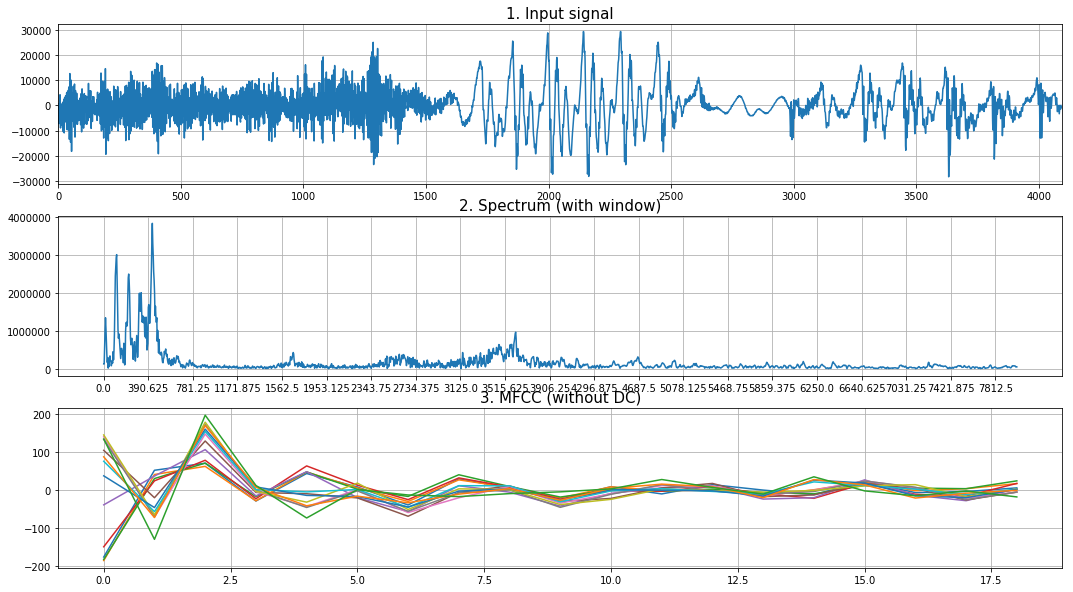

-------------------
-------------------
-------------------
0.256 3.90625
mean: 18.7912597656 std: 327.634779089 mean/std: 0.0573542888758
mean: 2153.28655983 std: 7340.8334032 mean/std: 0.293329986061
39780.7770348 259430.910629 0.153338616969
max-val: 259430.910629 max-freq: 58.59375 max/std: 35.3407980238
mfcc shape (20, 13)


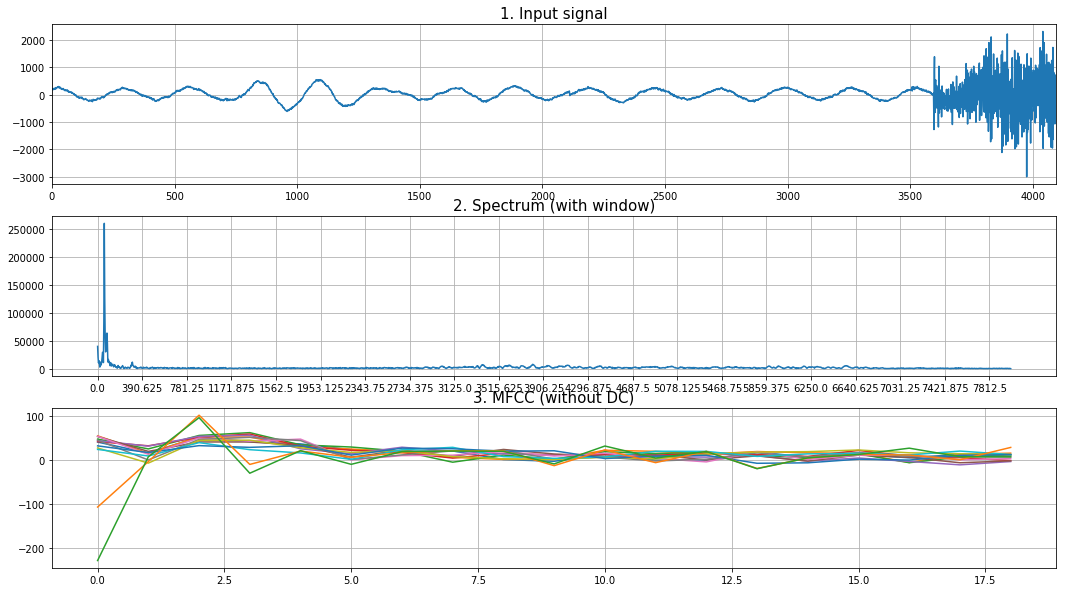

0.256 3.90625
mean: 19.2600097656 std: 601.0178338 mean/std: 0.0320456543591
mean: 10280.2723581 std: 10236.1534786 mean/std: 1.00431010336
36815.0303466 229384.137316 0.160495101263
max-val: 229384.137316 max-freq: 58.59375 max/std: 22.4092123859
mfcc shape (20, 13)


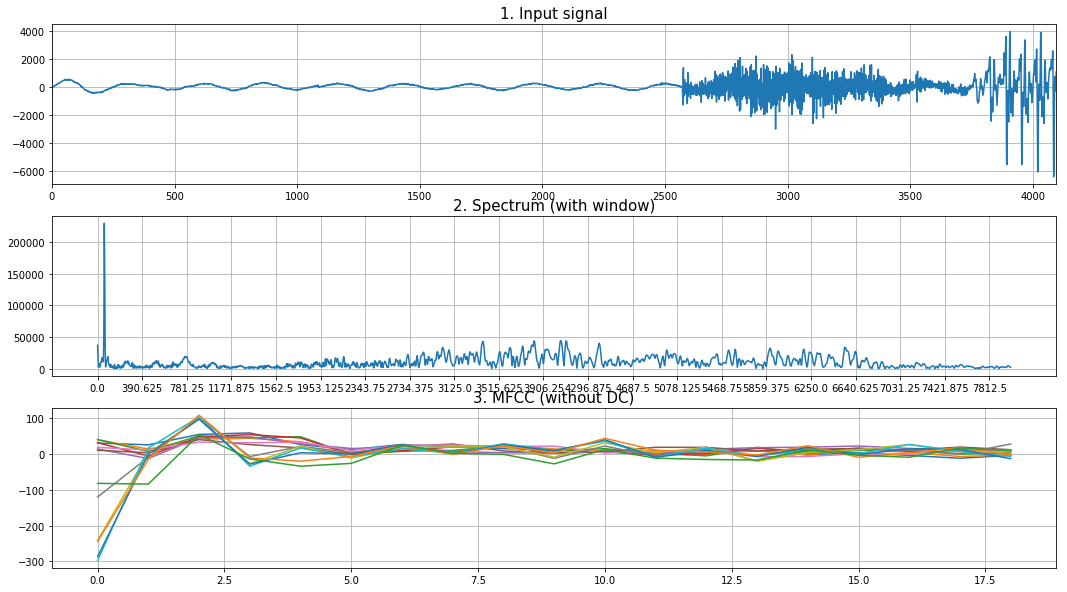

0.256 3.90625
mean: 12.9987792969 std: 916.28308835 mean/std: 0.0141864228011
mean: 24697.600959 std: 21833.8806895 mean/std: 1.1311594723
31596.3635679 223047.833599 0.141657343441
max-val: 223047.833599 max-freq: 58.59375 max/std: 10.2156752055
mfcc shape (20, 13)


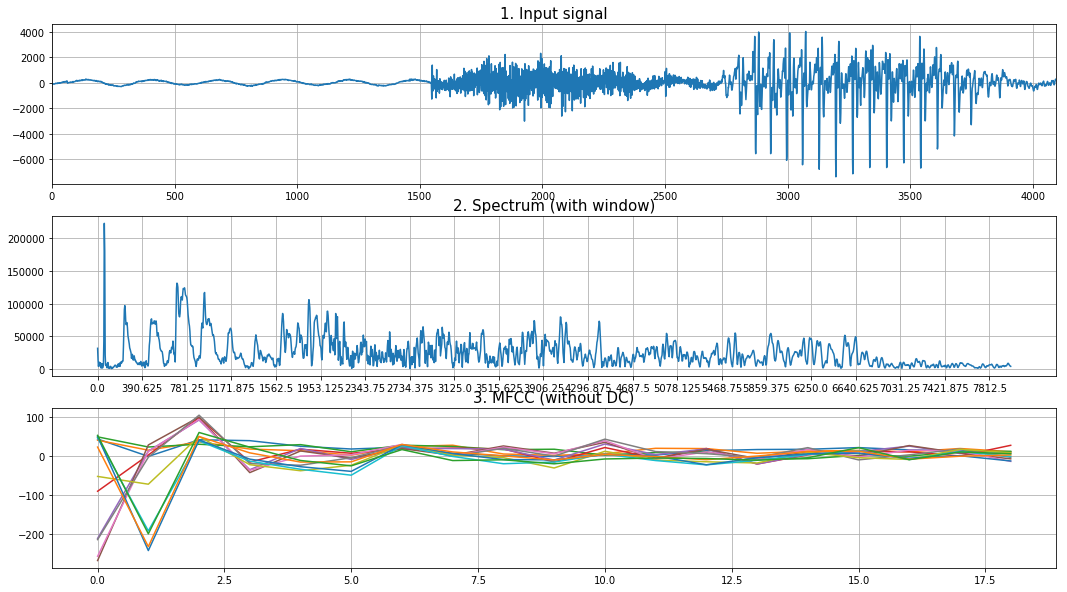

0.256 3.90625
mean: 9.36694335938 std: 918.33312974 mean/std: 0.0101999405837
mean: 28910.3134356 std: 43932.4902464 mean/std: 0.658062251273
29287.9013415 376264.622633 0.0778385731206
max-val: 376264.622633 max-freq: 695.3125 max/std: 8.56460948429
mfcc shape (20, 13)


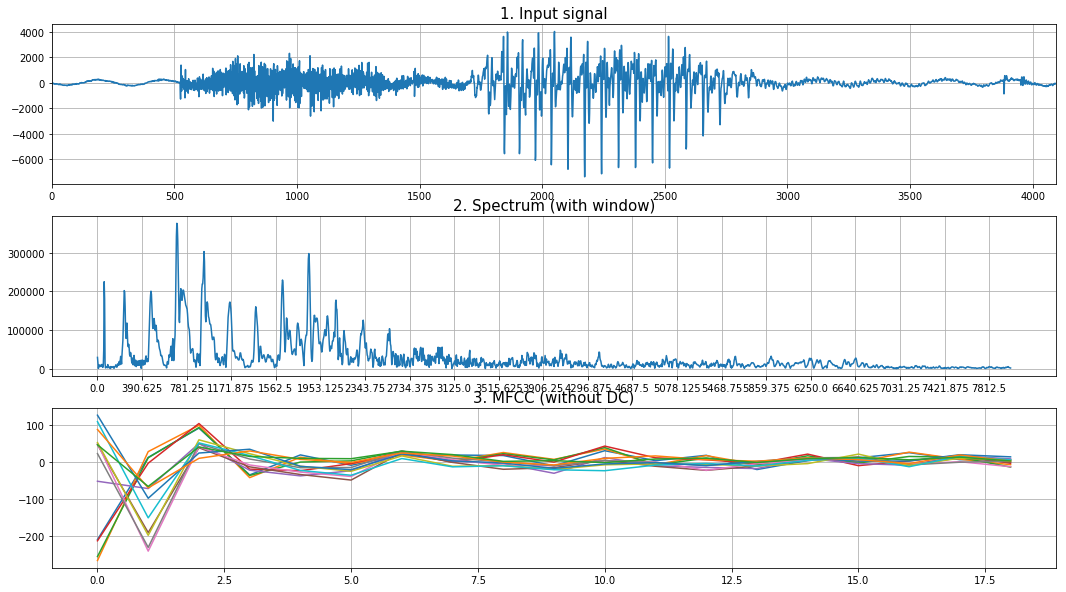

0.256 3.90625
mean: 14.5432128906 std: 1075.18793442 mean/std: 0.0135262054428
mean: 16986.1096179 std: 33327.634517 mean/std: 0.50967042408
28508.6021707 319165.080057 0.0893224351664
max-val: 319165.080057 max-freq: 695.3125 max/std: 9.57658965847
mfcc shape (20, 13)


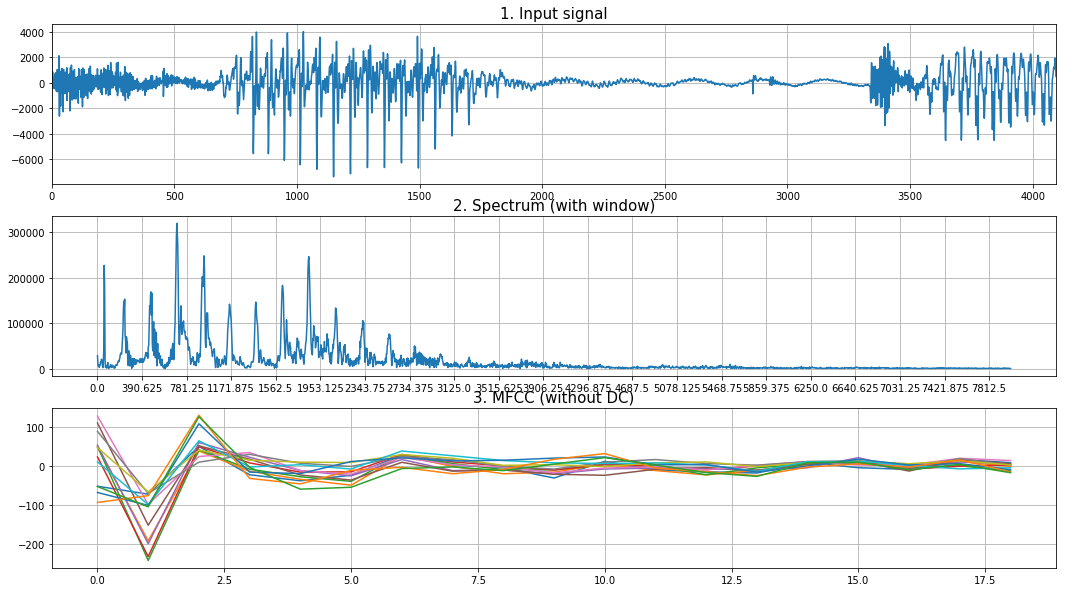

0.256 3.90625
mean: 18.1779785156 std: 1058.0822255 mean/std: 0.0171801189715
mean: 16471.1542389 std: 28985.9900633 mean/std: 0.568245355874
31794.2098324 348191.51824 0.0913124190765
max-val: 348191.51824 max-freq: 476.5625 max/std: 12.0124072864
mfcc shape (20, 13)


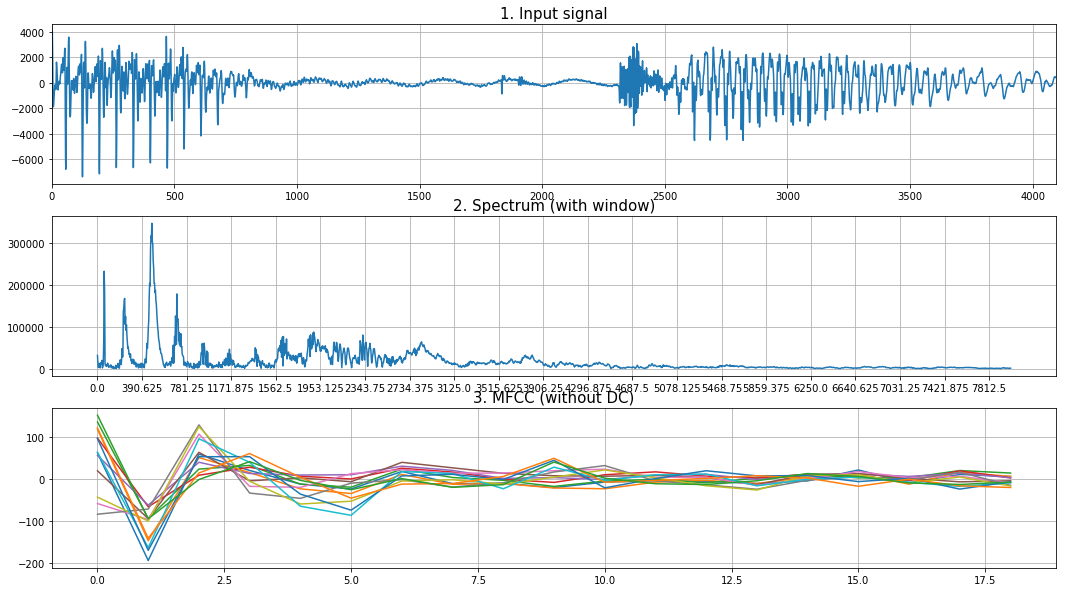

0.256 3.90625
mean: 17.583984375 std: 937.855052443 mean/std: 0.0187491492733
mean: 20054.8867316 std: 43067.3380588 mean/std: 0.465663485033
36612.2707467 486694.001354 0.0752264680575
max-val: 486694.001354 max-freq: 468.75 max/std: 11.3007681294
mfcc shape (20, 13)


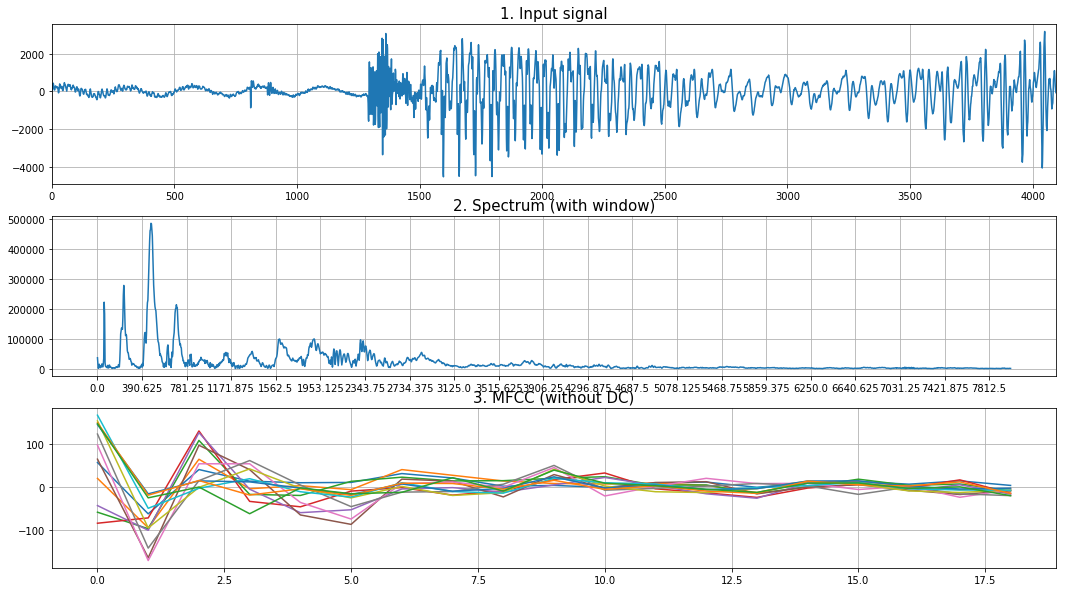

0.256 3.90625
mean: 15.6906738281 std: 1154.05759979 mean/std: 0.0135960924576
mean: 15123.2562652 std: 35621.4493966 mean/std: 0.424554770268
34159.8601258 300537.377966 0.113662601161
max-val: 300537.377966 max-freq: 203.125 max/std: 8.43697780571
mfcc shape (20, 13)


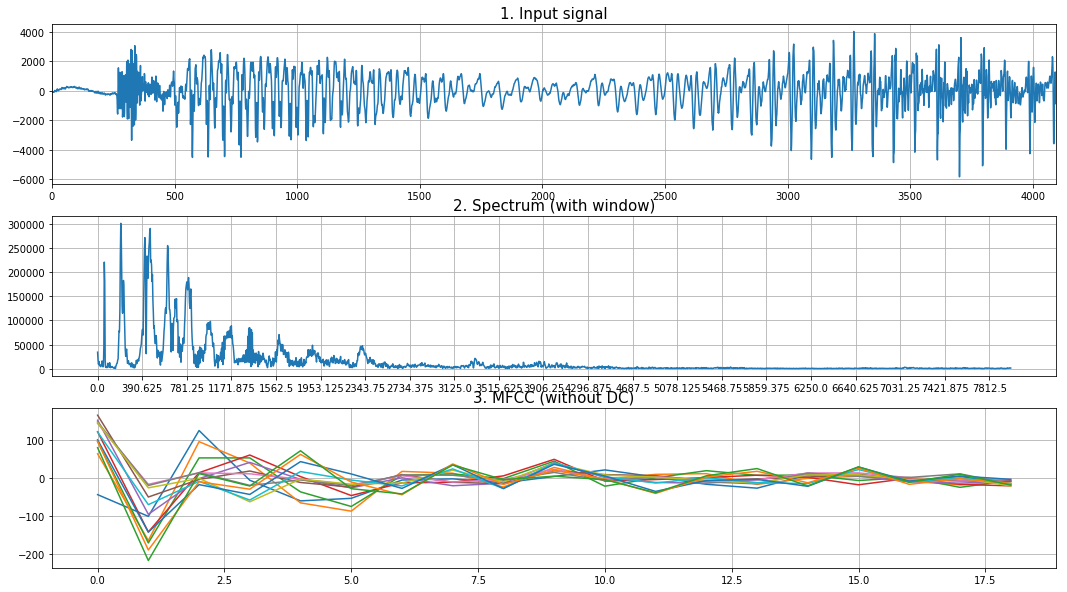

0.256 3.90625
mean: 10.7868652344 std: 1031.93475359 mean/std: 0.0104530496689
mean: 22979.397625 std: 43718.614018 mean/std: 0.525620451178
27755.1122448 354270.95217 0.0783443070192
max-val: 354270.95217 max-freq: 777.34375 max/std: 8.10343511859
mfcc shape (20, 13)


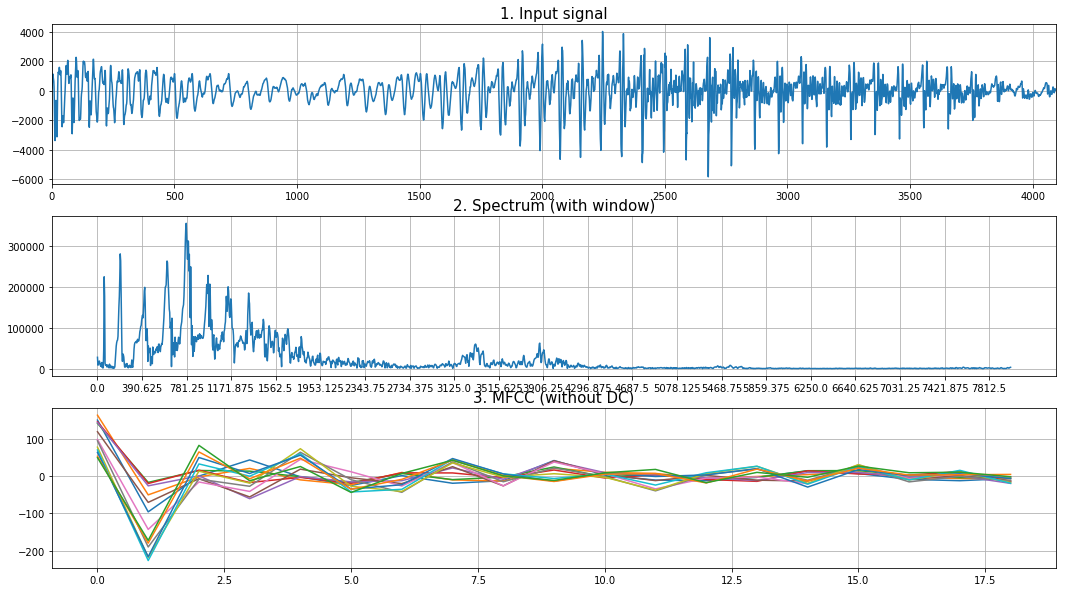

0.256 3.90625
mean: 10.0485839844 std: 920.778626827 mean/std: 0.0109131377419
mean: 22290.7510821 std: 35794.5834822 mean/std: 0.622740898582
28562.5757813 249616.312676 0.114425918223
max-val: 249616.312676 max-freq: 804.6875 max/std: 6.97357779843
mfcc shape (20, 13)


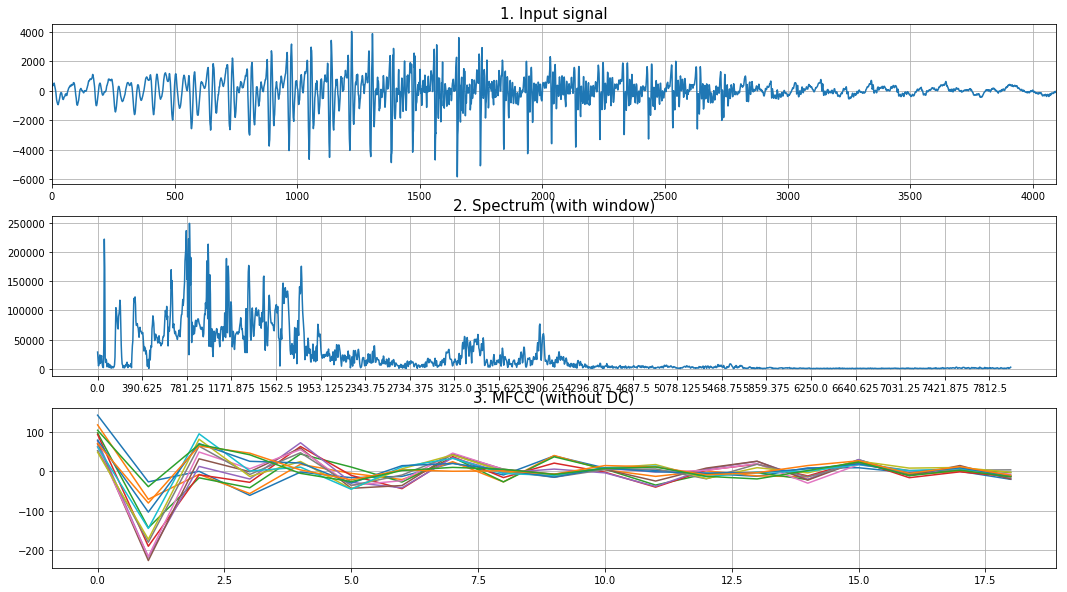

0.256 3.90625
mean: 12.4340820312 std: 779.09708548 mean/std: 0.0159596053727
mean: 10416.4138053 std: 18717.74505 mean/std: 0.556499395492
32550.9085062 219487.244941 0.148304328641
max-val: 219487.244941 max-freq: 58.59375 max/std: 11.7261584852
mfcc shape (20, 13)


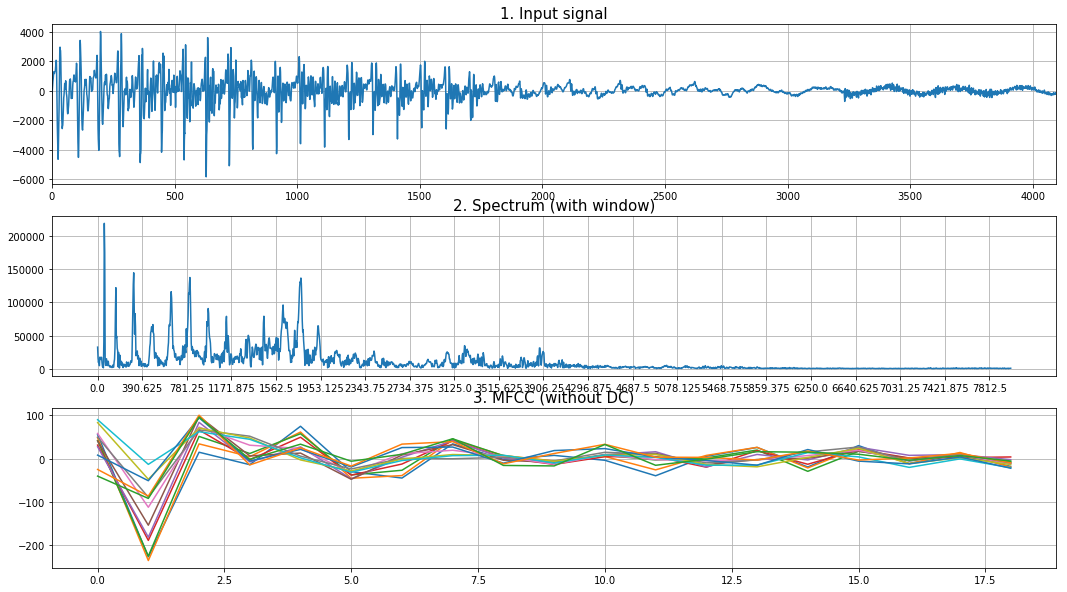

0.256 3.90625
mean: 15.8486328125 std: 389.625944339 mean/std: 0.0406765335902
mean: 3874.19313162 std: 8337.3178743 mean/std: 0.464680990941
33582.6999658 222456.408041 0.150963059512
max-val: 222456.408041 max-freq: 58.59375 max/std: 26.682011097
mfcc shape (20, 13)


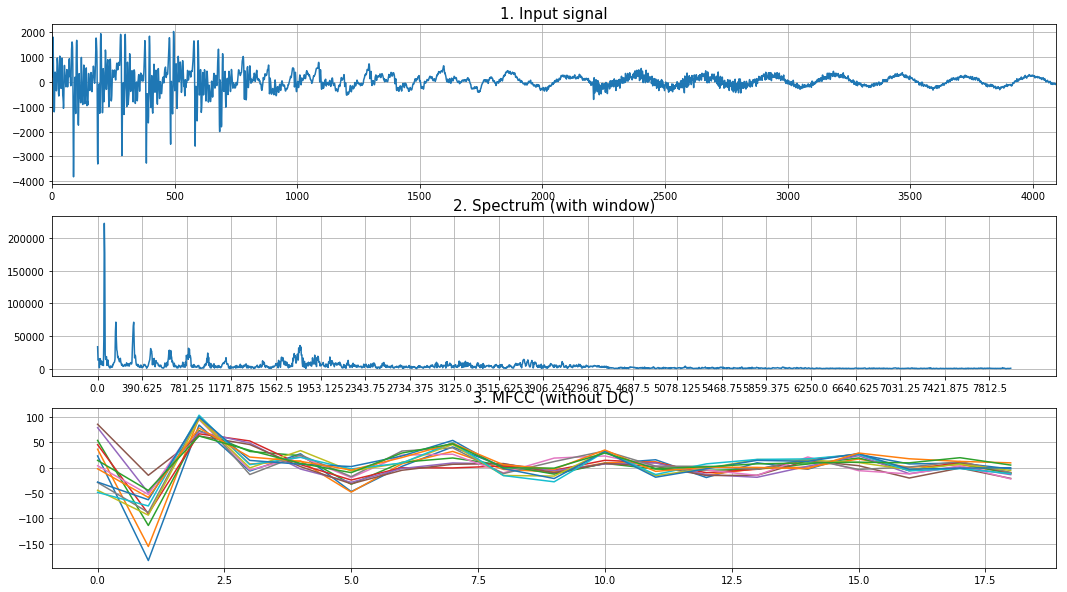

0.256 3.90625
mean: 8.66064453125 std: 274.63548831 mean/std: 0.03153505246
mean: 1058.14864652 std: 6434.54838771 mean/std: 0.164448005169
28233.0422973 216826.082098 0.130210544895
max-val: 216826.082098 max-freq: 58.59375 max/std: 33.6971717412
mfcc shape (20, 13)


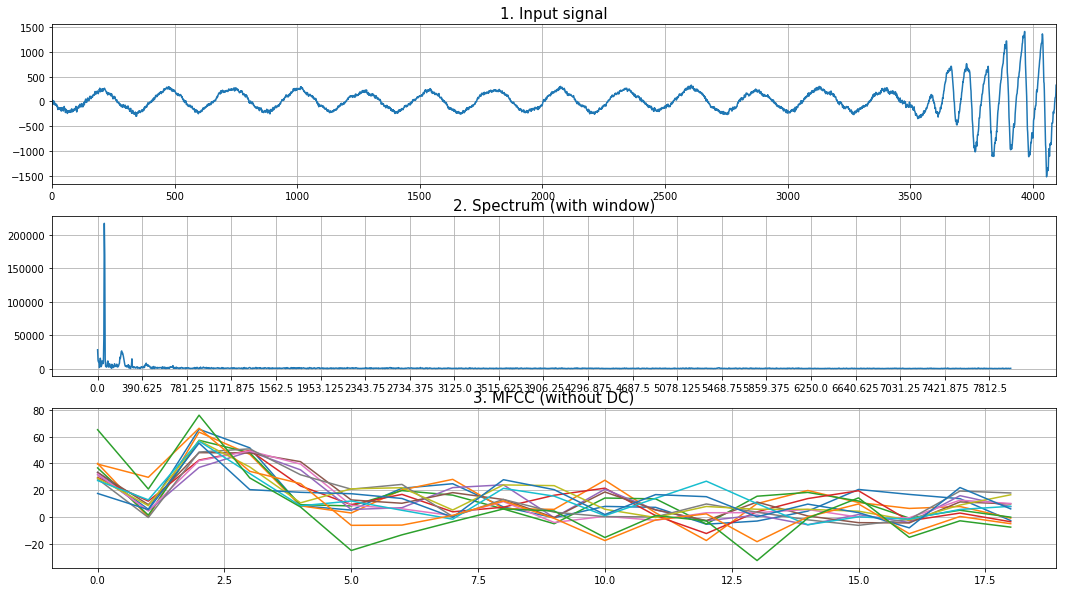

In [211]:
e = 0
for x,y in zip(x_train[500:700],y_train[500:700]):
    if y == 0:
        fft_plot(x,16000)
        e +=1
        write_wav("./{}_man.wav".format(e),16000,x)
    if e>12:
        break
    
print("-------------------")
print("-------------------")
print("-------------------")
        
e = 0
for x,y in zip(x_train[:100],y_train[:100]):
    if y == 1:
        fft_plot(x,16000)
        e +=1
        write_wav("./{}_woman.wav".format(e),16000,x)
    if e>12:
        break
        

In [164]:
print(x_train.shape)
print(x_test.shape)

(10000, 1024)
(1254, 1024)


In [166]:
#     mfccs = mfcc(data, sr=fs, n_mfcc=30, n_fft=1024)
X_train = np.array([mfcc(x, sr=16000, n_mfcc=21, n_fft=1024)[1:] for x in x_train])
X_test = np.array([mfcc(x, sr=16000, n_mfcc=21, n_fft=1024)[1:] for x in x_test])

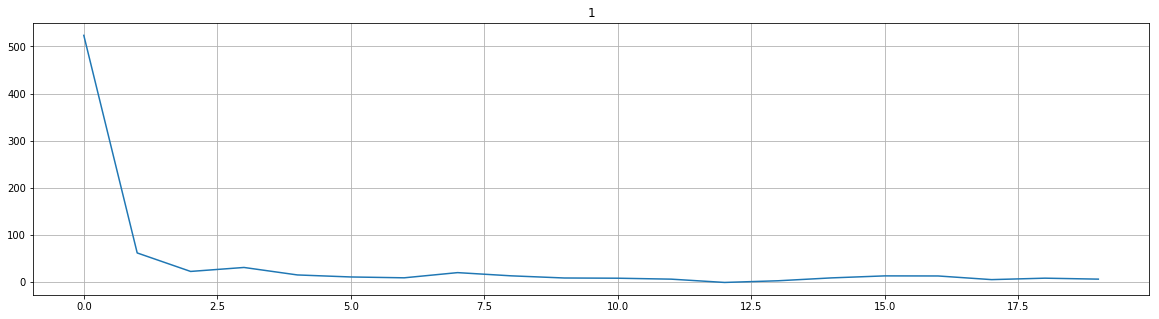

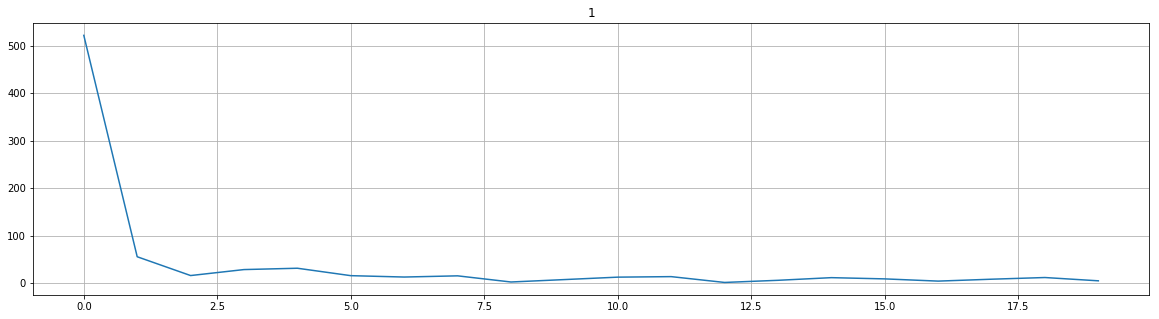

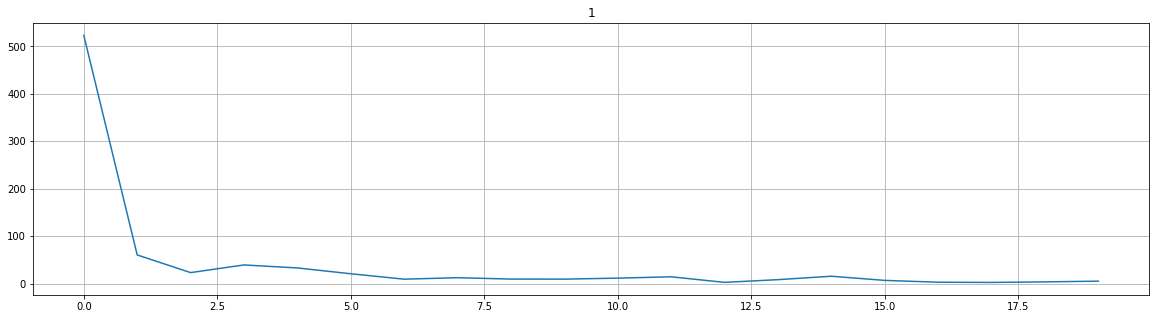

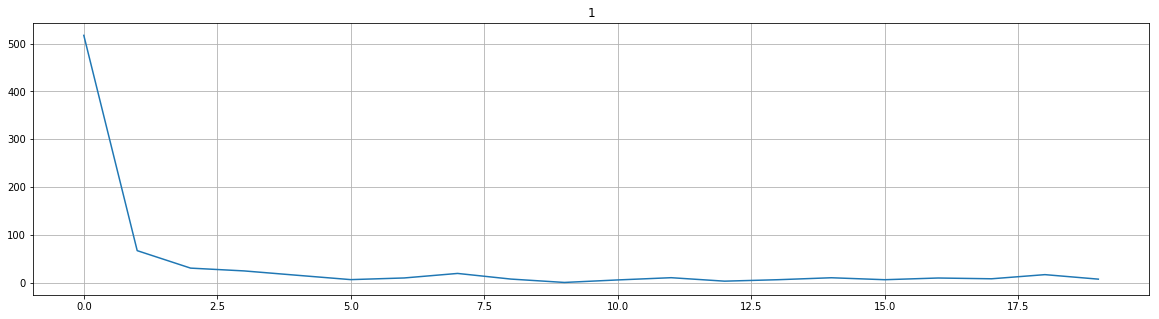

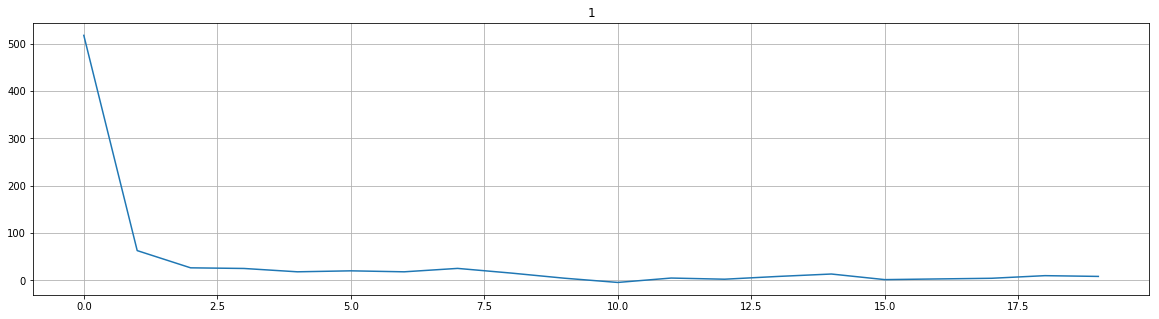

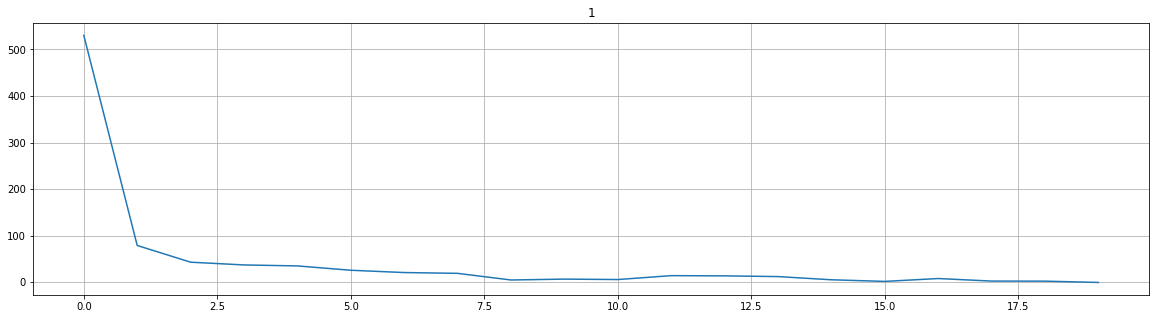

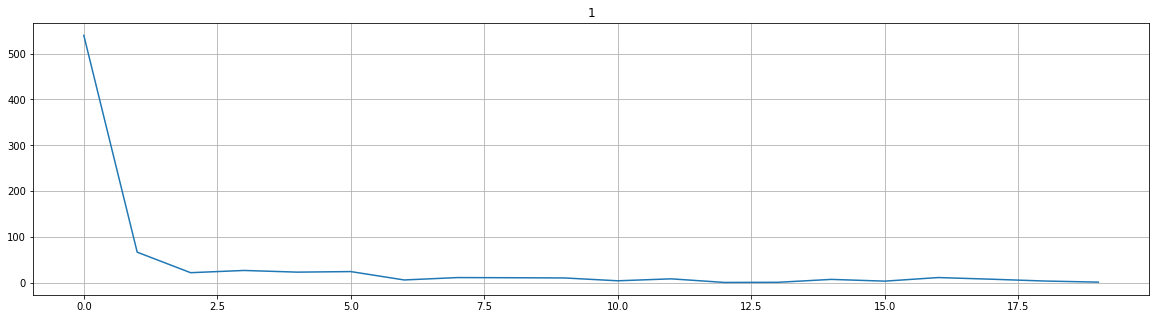

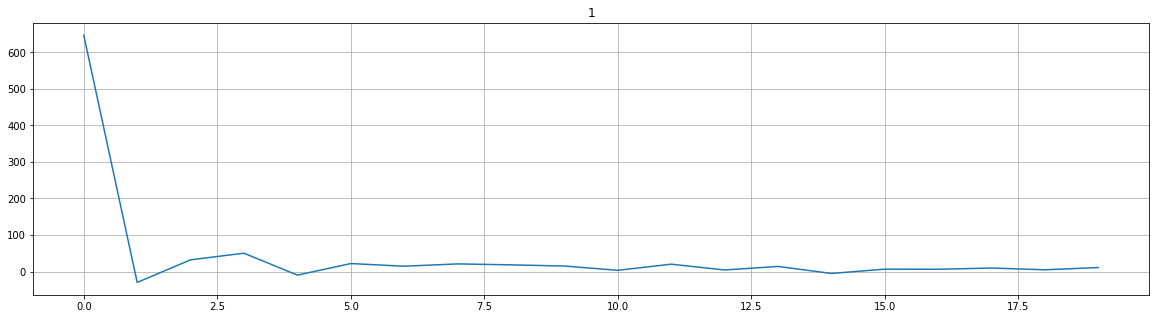

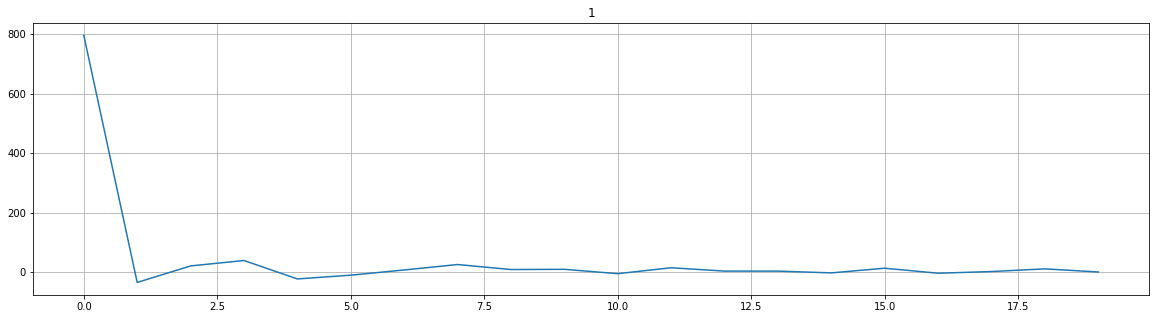

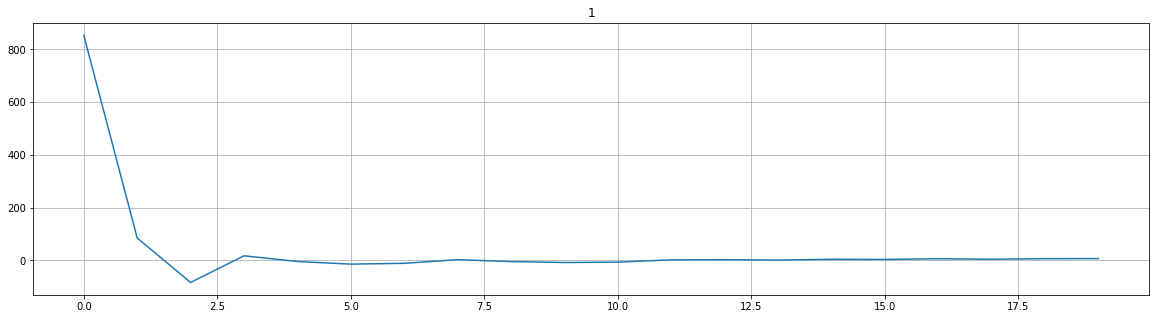

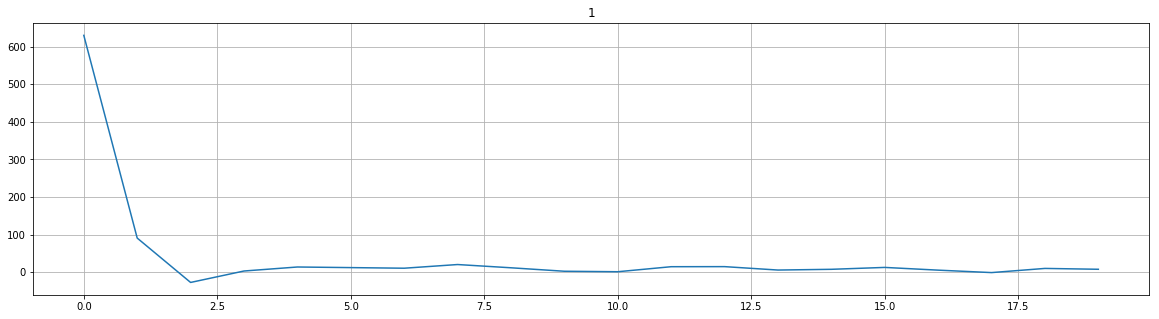

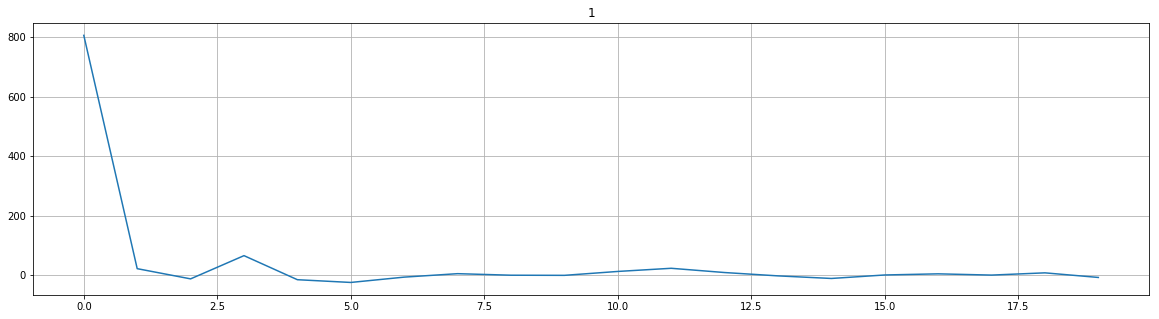

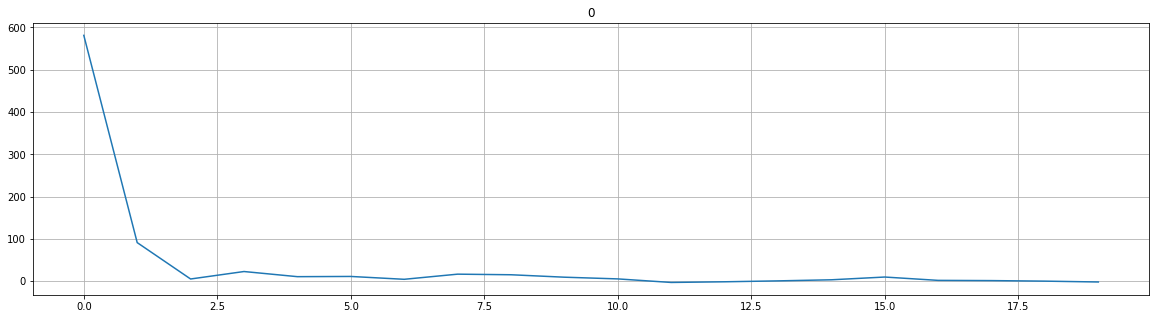

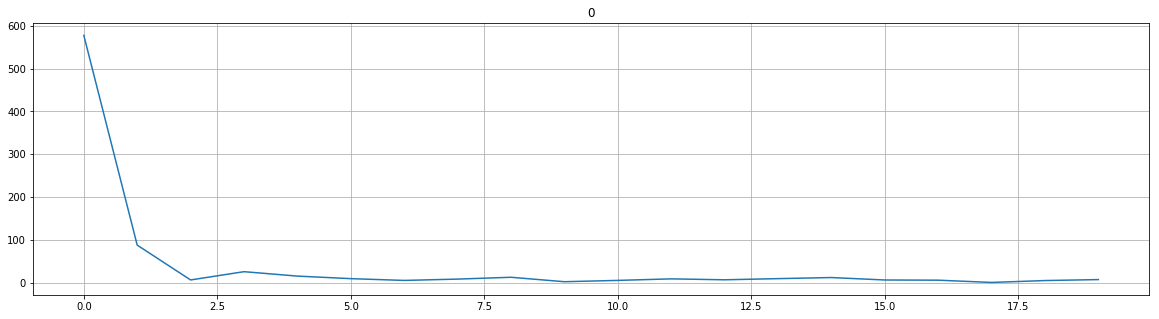

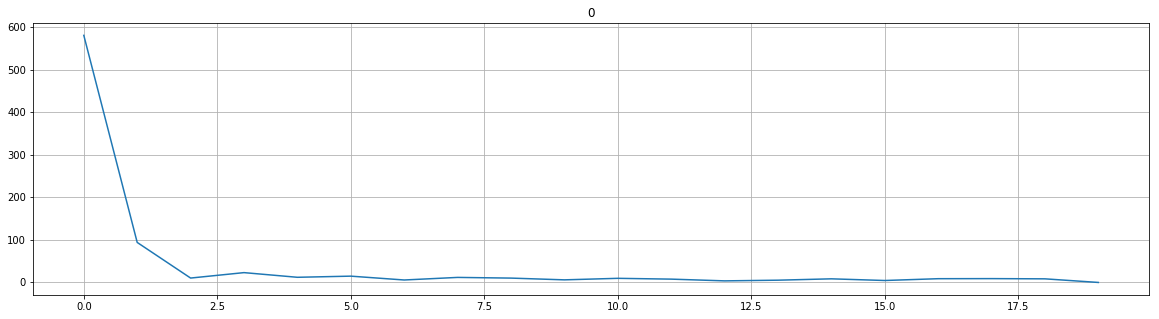

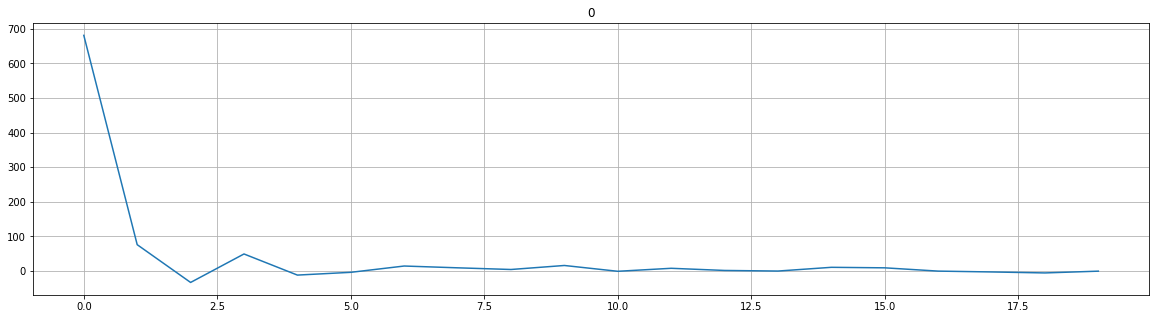

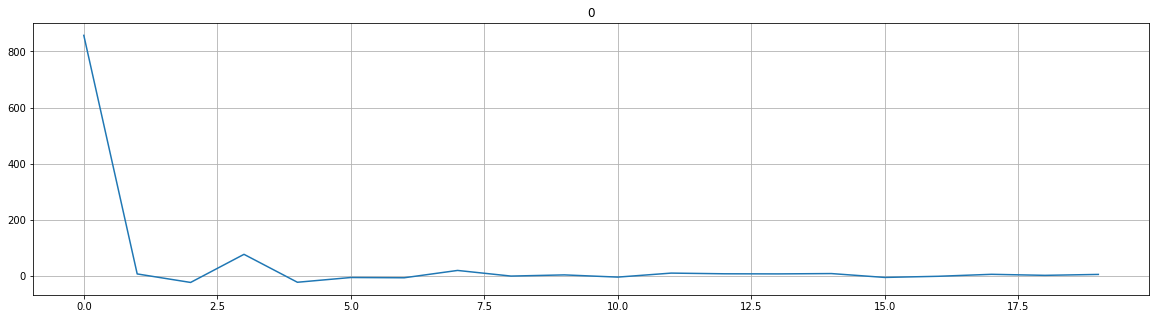

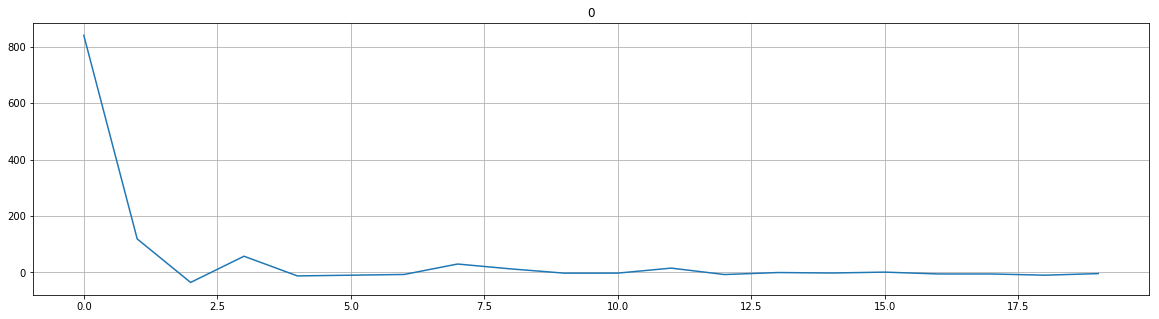

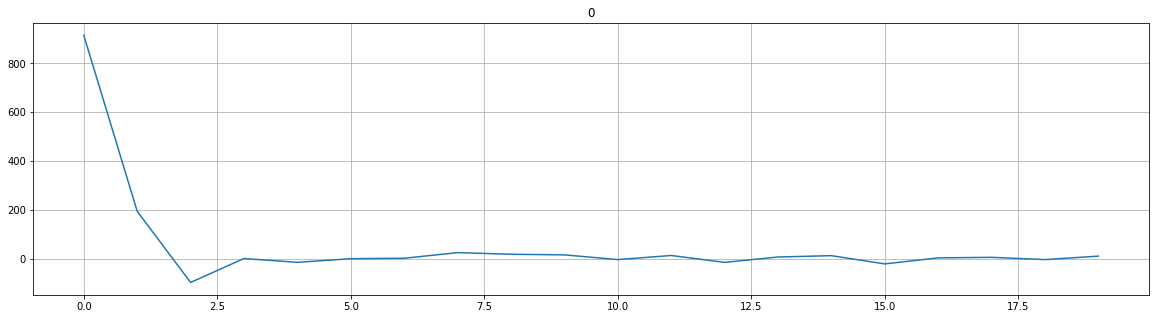

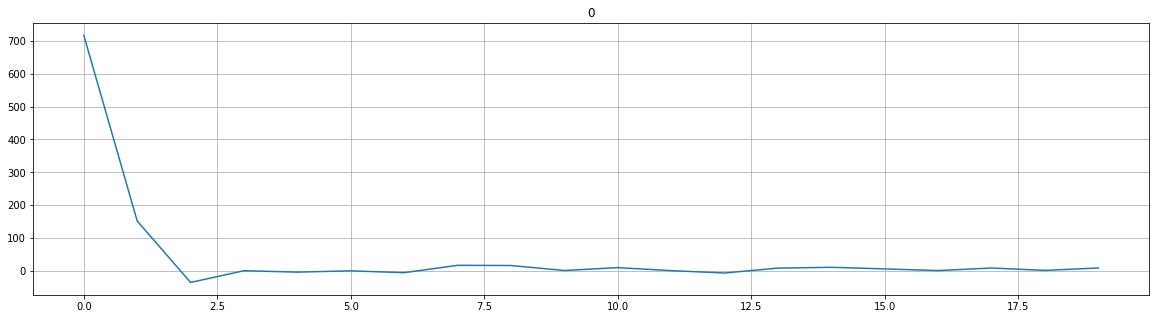

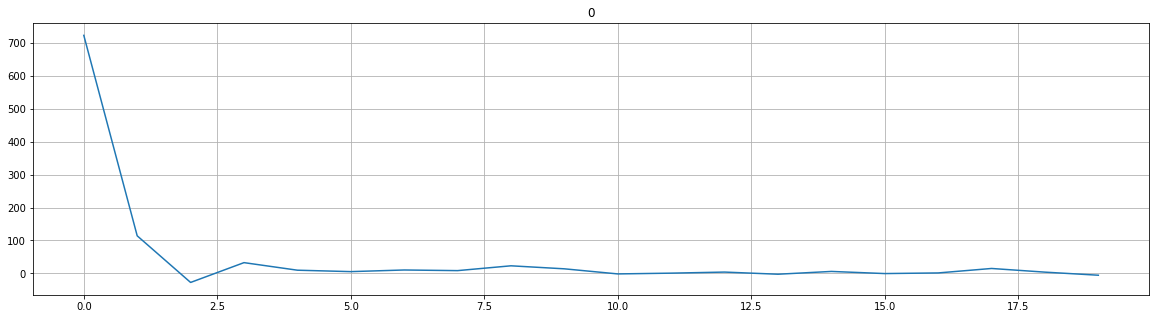

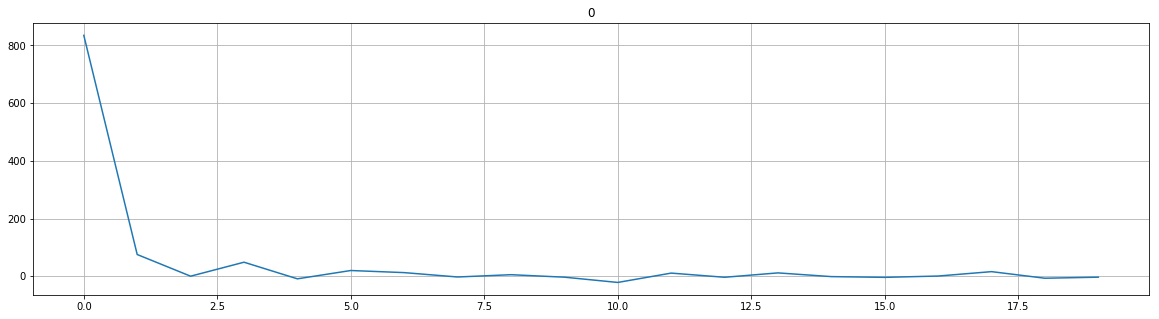

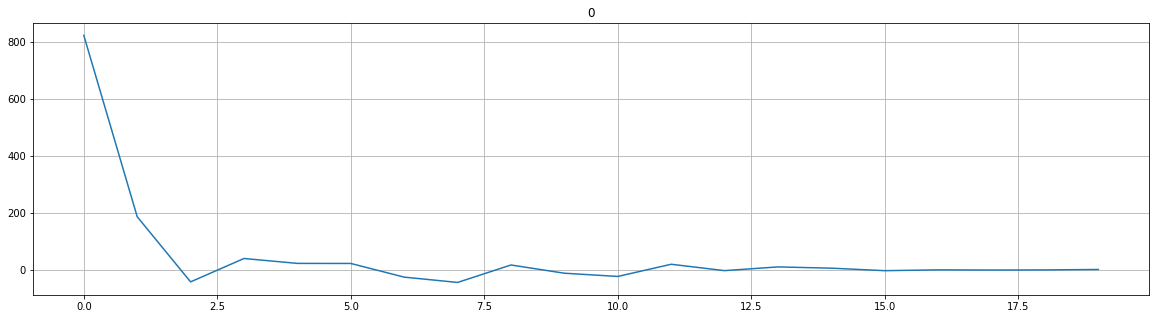

In [69]:
for e,(x,y) in enumerate(zip(X_train,y_train)):
    plt.figure(figsize=(20,5))
    plt.plot(x)
    plt.grid()
    plt.title(y)
    plt.show()
    if e > 10:
        break
e=0
for x,y in zip(X_train,y_train):
    if y == 0 :
        e+=1 
        plt.figure(figsize=(20,5))
        plt.plot(x)
        plt.grid()
        plt.title(y)
        plt.show()
    if e > 10:
        break

In [172]:
X_train = X_train.reshape(-1,20,1)
X_test = X_test.reshape(-1,20,1)

In [176]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.layers import Activation
from keras.layers import LSTM, Dense, Embedding, Bidirectional

In [169]:
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)

In [175]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

num_classes = 2
batch_size = 50
epochs = 200

# LSTM model
model = Sequential()
model.inputs
model.add(LSTM(10, input_shape=(20,1)))
model.add(Dense(2))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

# フィッティング(学習)
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)
#                     validation_data=(X_test, Y_test))

# # スコア計算・表示
# score = model.evaluate(X_test, Y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

(10000, 20, 1)
(10000, 2)
(1254, 20, 1)
(1254, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 502
Trainable params: 502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
10000/10000 [==============================] - 11s - loss: 0.6694 - acc: 0.5745    
Epoch 2/200
10000/10000 [==============================] - 10s - loss: 0.6441 - acc: 0.6212    
Epoch 3/200
10000/10000 [==============================] - 11s - loss: 0.6282 - acc: 0.6420    
Epoch 4/200
10000/10000 [==============================] - 11s - loss:

KeyboardInterrupt: 

In [179]:
## Bidirectional version

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

num_classes = 2
batch_size = 50
epochs = 200

# LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(10), input_shape=(20,1)))
model.add(Dense(2))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

# フィッティング(学習)
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)
#                     validation_data=(X_test, Y_test))

# # スコア計算・表示
# score = model.evaluate(X_test, Y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

(10000, 20, 1)
(10000, 2)
(1254, 20, 1)
(1254, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 20)                960       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 1,002
Trainable params: 1,002
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
10000/10000 [==============================] - 12s - loss: 0.6485 - acc: 0.6165    
Epoch 2/200
10000/10000 [==============================] - 10s - loss: 0.6180 - acc: 0.6537    
Epoch 3/200
10000/10000 [==============================] - 10s - loss: 0.6006 - acc: 0.6697    
Epoch 4/200
10000/10000 [==============================] - 10s - l

KeyboardInterrupt: 

In [47]:
print('Train...')

for epoch in range(10):
    mean_tr_acc = []
    mean_tr_loss = []
    
    for i in range(int(len(X_train)/50)):
        if i%100 == 0:
            print(i*50)
        
        ind = i
        
        Y_true = Y_train[ind*50:(ind+1)*50]
        s_true = s_train[ind]
        

        batch = X_train[i*50:(i+1)*50].T
        
        for j in range(20):
            #batch 100,20,1
            mini_batch = batch[j]
            tr_loss, tr_acc = model.train_on_batch(mini_batch.reshape(50,1,1), Y_true)
#         model.reset_states()

        mean_tr_acc.append(tr_acc)
        mean_tr_loss.append(tr_loss)
        
        
    print('accuracy training = {}'.format(np.mean(mean_tr_acc)))
    print('loss training = {}'.format(np.mean(mean_tr_loss)))
    print('___________________________________')
    
    
#     mean_ts_acc = []
#     mean_ts_loss = []
    
#     for i in range(int(len(X_test))):
#         if i%100 == 0:
#             print(i)

#         Y_true = Y_test[i*50:(i+1)*50]
#         s_true = s_test[i]

#         batch = X_test[i*50:(i+1)*50].T
        
#         for j in range(20):
#             ts_loss, ts_acc = model.test_on_batch(batch[j].reshape(50,1,1), np.array([Y_true]))
#         model.reset_states()

#         mean_ts_acc.append(ts_acc)
#         mean_ts_loss.append(ts_loss)

# #         if s_true != 80:
# #             if s_true != s_test[i]:
# #                 model.reset_states()

#     print('accuracy testing = {}'.format(np.mean(mean_ts_acc)))
#     print('loss testing = {}'.format(np.mean(mean_ts_loss)))
#     print('___________________________________')


Train...
0
5000
10000
accuracy training = 0.43913334608078003
loss training = 9.0401029586792
___________________________________
0
5000
10000
accuracy training = 0.43913334608078003
loss training = 9.0401029586792
___________________________________
0


KeyboardInterrupt: 

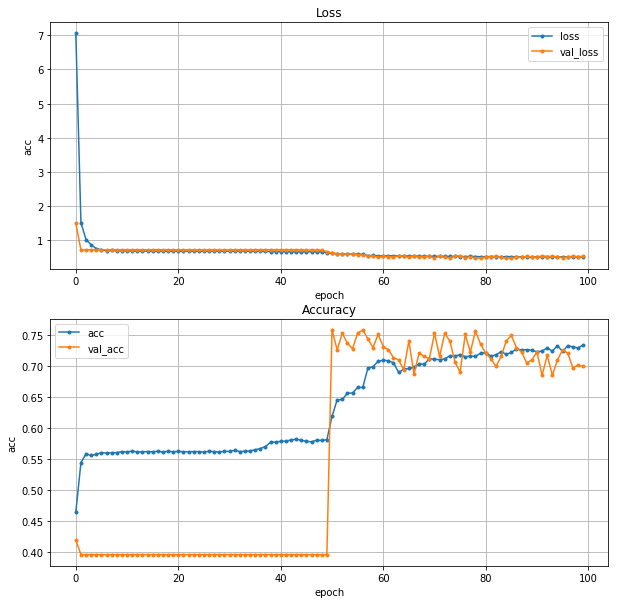

In [94]:
import matplotlib.pyplot as plt
# plot results
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Loss')
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')

plt.subplot(2,1,2)
plt.title('Accuracy')
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

# plt.savefig('rms_cifar3_50epochs.png')

In [201]:
from scipy import arange, hamming, sin, pi
from scipy.fftpack import fft, ifft
import numpy as np
import librosa


def fft_plot(data,fs):
    # fs = Sampling rate
    L = len(data) # Signal length（サンプル数）

    data_length = L /fs
    delta_freq = 1/data_length
    print(data_length,delta_freq)
    print("mean:",np.mean(data),"std:",np.std(data),"mean/std:",np.mean(data)/np.std(data))

    # 窓関数
    win = hamming(L)

    # フーリエ変換
    spectrum = fft(data * win) # 窓関数あり
    half_spectrum = abs(spectrum[: int(L / 2) + 1])
    mean = np.mean(half_spectrum)
    std = np.std(half_spectrum)
    max_val = np.max(half_spectrum)
    max_freq = np.argmax(half_spectrum)*delta_freq
    
    print("mean:",mean,"std:",std,"mean/std:",mean/std)
    
    print(np.max(half_spectrum[:10]),np.max(half_spectrum[10:]),np.max(half_spectrum[:10])/np.max(half_spectrum[10:]))
    print("max-val:",max_val,"max-freq:",max_freq,"max/std:",max_val/std)
    
    # mfccs translation
    mfccs = mfcc(data, sr=fs, n_mfcc=20, n_fft=1024)
    print("mfcc shape",mfccs.shape)
    
#     if mfccs[1] > mfccs[2]:
#         print("----OK----")
#     else:
#         print("----NG----")

    
    # 図を表示
    fig = plt.figure(figsize=(18,10))

    fig.add_subplot(311)
    plt.plot(data)
    plt.xlim([0, L])
    plt.grid()
    plt.title("1. Input signal", fontsize = 15)

    fig.add_subplot(312)
#     plt.plot(np.arange(len(spectrum))*delta_freq, spectrum)
    plt.plot(half_spectrum)
#     plt.xlim([0, len(half_spectrum)/10])
    plt.xticks([i for i in range(len(half_spectrum))][::100],[i*delta_freq for i in range(len(half_spectrum))][::100])
    plt.grid()
    plt.title("2. Spectrum (with window)", fontsize = 15)

    fig.add_subplot(313)
    plt.plot(mfccs[1:])
#     plt.xticks(np.arange(0,30),np.arange(1,31))
    plt.grid()
    plt.title("3. MFCC (without DC)", fontsize = 15)
    
    plt.show()

#     l = 512
#     data_length = l/fs
#     delta_freq = 1/data_length
#     print(data_length,delta_freq)
    
#     plt.figure(figsize=(20,10))
#     # スペクトログラムを描画
#     pxx, freqs, bins, im = plt.specgram(data, NFFT=l, Fs=fs, noverlap=0, window=hamming(l))
# #     plt.yticks(np.arange(20000)[::100],np.arange(20000)[::100]*delta_freq)
# #     plt.ylim(0,1000)
#     plt.xlabel("time [second]")
#     plt.ylabel("frequency [Hz]")

#     plt.show()
    
#     return (np.arange(len(half_spectrum))*delta_freq, half_spectrum)
    return (np.arange(len(spectrum))*delta_freq, spectrum)

In [210]:
from librosa.core import stft, spectrum
from librosa.filters import mel, dct

def mfcc(y, sr=22050, n_mfcc=20, n_fft=2048, center=False, power=2.):

    abs_spectrum = np.abs(spectrum.stft(y, n_fft=n_fft, center=False))**power

    mel_basis = mel(sr, n_fft, n_mels=512)
    melspec = np.dot(mel_basis, abs_spectrum)

    S =spectrum.power_to_db(melspec)

    return np.dot(dct(n_mfcc, S.shape[0]), S)

